# Lab Feedback 03

Here are some suggested solutions for the exercises for this week's practical session. Note that these aren't the only - or indeed necessarily the "best" - solutions.

## Part 1: Outliers

Here we identify possible outliers and observe the effects of removing them.

### 1. Load the data

In [2]:
import numpy as np
import pandas as pd

# Load the CSV file into a Pandas dataframe
cars = pd.read_csv('accord_sedan.csv')
#print (passenger.head()) # check it's loaded

### 2. Plot "price" and "mileage"

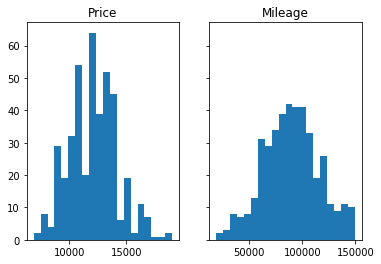

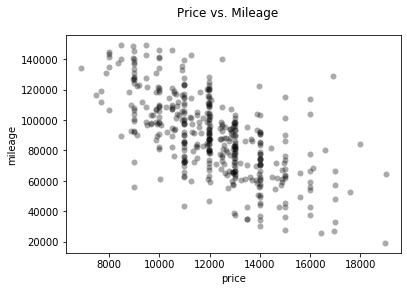

In [4]:
import matplotlib.pyplot as plt

# Show histograms
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(cars['price'], 20)
ax1.set_title('Price')
ax2.hist(cars['mileage'], 20)
ax2.set_title('Mileage')
plt.show()

plt.xlabel('price')
plt.suptitle('Price vs. Mileage')
plt.ylabel('mileage')
# setting the points to be slightly transparent to better appreciate density
plt.scatter(cars['price'], cars['mileage'] , linewidth = 0, c="#00000055")

### 3. Visually identify the outliers

Which points look like outliers?

### 4. Identify outliers from the statistics of the distribution

Add two new columns: `isOutlierPrice` and `isOutlierMileage`, and put a 1 if the value is an outlier, (defined as more that twice the standard deviation from the mean); otherwise put a 0;

You can use DataFrame's `loc()` funtion to assess a specific cell

Below, there are three alternative ways of calculating/storing whether each point is an outlier
1. Iterate (slowest way)
1. Use pandas to select the rows that meet the condition, then set all these to 1
1. Use numpy to assign a 1 if the condition is met; otherwise a zero

In [5]:
# create new columns, filled with 0s
cars['isOutlierPrice'] = 0 
cars['isOutlierMileage'] = 0

# calculate the mean and standard deviations
meanPrice = cars['price'].mean()
stdDevPrice = cars['price'].std()
meanMil = cars['mileage'].mean()
stdDevMil = cars['mileage'].std()

#Only ONE of the alternatives (below) is needed!


#ALTERATIVE 1
# Use a loop. There are many ways of even doing that. The enumerate() function returns
# the index (i) AND the value (val). The second one uses the loop differently
#To avoid copy warnings, use loc which ensures you access the dataframe directly
for i,val in enumerate(cars['price']):
    if abs(val - meanPrice) > 2 * stdDevPrice:
        cars.loc[i,"isOutlierPrice"] = 1

for i in range(len(cars)):
    if abs(cars.loc[i,"isOutlierMileage"] - meanMil) > 2 * stdDevMil:
        cars.loc[i,"isOutlierMileage"] = 1

# ALTERATIVE 2        
# use a filter. More efficent not to explictly use loop. Use loc as before,
# but filter rows on the outlier condition
cars.loc[abs(cars['price'] - meanPrice) > 2 * stdDevPrice,'isOutlierPrice'] = 1
cars.loc[abs(cars['mileage'] - meanMil) > 2 * stdDevMil,'isOutlierMileage'] = 1

# ALTERATIVE 3
#Uses numpy where() function where you give it a condition
cars['isOutlierPrice'] = np.where(abs(cars['price'] - meanPrice) > 2 * stdDevPrice, 1, 0)
cars['isOutlierMileage'] = np.where(abs(cars['mileage'] - meanMil) > 2 * stdDevPrice, 1, 0)


#This counts the unique values
from collections import Counter
print(Counter(cars['isOutlierPrice']))
print(Counter(cars['isOutlierMileage']))

Counter({0: 400, 1: 17})
Counter({1: 360, 0: 57})


### 5. Colour dots on plot

Identify the "outliers" on the scatterplot. Create a list and put a colour for each row, coloured according to the values of `isOutlierPrice` and `isOutlierMileage`.

We do this by creating a new list that will contain the colour per row.

Colours are commonly specified in *hexadecimal*, with pairs of 0-f values corresponding to red, green and blue (and optionally opacity). So #ff0000 is red, #00ff00 is green and #0000ff is blue (a fourth pair of hexadecimal values will change the transparency) [See this](https://www.w3schools.com/colors/colors_picker.asp).

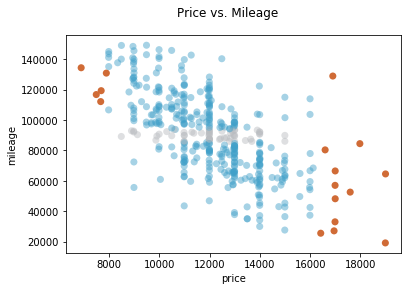

In [6]:
# first create an empty list
colorColumn = []
# we make use of the HEX color codes
# Adobe Color CC is a nice resource to find colors (https://color.adobe.com/)
for i in range(len(cars)):
    if cars["isOutlierPrice"][i] == 1:
        colorColumn.append("#D06B36ff") # orange color
    elif cars["isOutlierMileage"][i] == 1:
        colorColumn.append("#40A0C977") # a blueish color
    else:
        colorColumn.append("#B9BCC077") # gray

plt.xlabel('price')
plt.suptitle('Price vs. Mileage')
plt.ylabel('mileage')
plt.scatter(cars.price, cars.mileage , c = colorColumn, s = 50, linewidth= 0)

### 6. Optional: identify 2D outliers using Mahalanobis distance

Find the 2D mean vector, the 2D Mahalanobis distances of each point to this, then colour them according to their mahalanobis score. Compare your observations in step-3 to the resulting scatterplot.

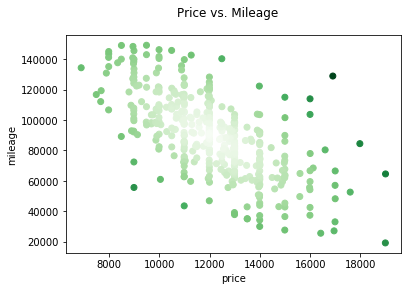

In [7]:
# We now get a part of the data frame as a numpy matrix to use in scipy
columnValues = cars[["price", "mileage"]].values

# We generate a "mean vector" directly from the means we computed above.
# The reshape() function gets is the shape that we need.
meanVector = np.asarray([meanPrice, meanMil ]).reshape(1,2)

# We make use of the scipy function which does the computations itself.
# Alternatively, one can provide a covariance matrix that is computed outside as a parameter.
# In cases where robustness of the covariance matrix is the issue, this can be a good option.

# first import the spatial subpackage from scipy
from scipy import spatial
mahalanobisDistances = spatial.distance.cdist(columnValues, meanVector, 'mahalanobis')[:,0]

# We create a new figure where we use a color mapping and use the computed mahalanobis distances 
# as the mapping value
plt.xlabel('price')
plt.suptitle('Price vs. Mileage')
plt.ylabel('mileage')
plt.scatter(cars.price, cars.mileage , c = mahalanobisDistances, cmap = plt.cm.Greens)

We can see that more "central" points have a low Mahalanobis distance. In this plot, the only clear 2D outlier is the dark point on the left top corner.

You wouldn't normally use the Mahalanobis for 2D data. Mahalanobis distance takes the variation of the data into account and it is able capture elliptical relations as it makes use of the covariance information. In cases where you have several more variables (and it is hard to visually determine outliers), Mahalanobis distance becomes very handy.

## Part 2: Q-Q Plots

With the code below, we first choose a column and investigate its shape through a Q-Q plot. In order to observe the different shapes better and in particular to observe how data transformations affect the data, we'll try here to apply `log()` to our data. Firstly, we'll load the TB data from last week and we'll impute missing values so we have data to work with

In [8]:
import pandas as pd

tbDF= pd.read_csv('TB_burden_countries.csv')
tbDF = tbDF.fillna(tbDF.mean())

### 1. Pick a column

In [9]:
columnToTest = "e_prev_100k_hi"
# Also try `e_inc_tbhiv_num', 'c_cdr', 'e_prev_num' and 'e_prev_100k_hi'

### 2. Compare to a normal distribution

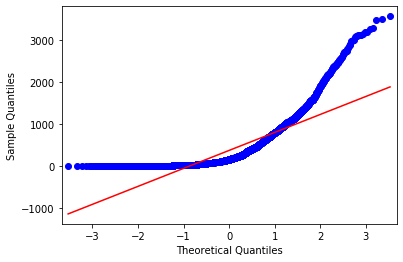

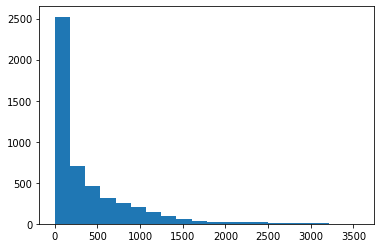

In [10]:
# We'll make use of the qqplot function from the stasmodel package
import statsmodels.api as sm
#This contains theoretical distributions
from scipy import stats

sm.qqplot(tbDF[columnToTest], dist=stats.norm, line = 'r')
plt.show()

ax2 = plt.hist(tbDF[columnToTest],20)
plt.show()

This isn't normally distributions, because the Q-Q plot isn't a straight and the histogram doesn't look normal. It's massively skewed to the left, suggesting more like a log distribution. Let's test this.

We can use Panda's `apply()` function to transform the variable.

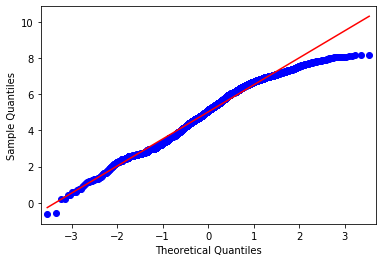

(array([  2.,   2.,   6.,  10.,  31.,  35.,  85., 308., 324., 371., 351.,
        462., 461., 497., 397., 478., 509., 375., 140.,  59.]),
 array([-0.61618614, -0.17643087,  0.26332441,  0.70307968,  1.14283496,
         1.58259023,  2.0223455 ,  2.46210078,  2.90185605,  3.34161132,
         3.7813666 ,  4.22112187,  4.66087714,  5.10063242,  5.54038769,
         5.98014296,  6.41989824,  6.85965351,  7.29940879,  7.73916406,
         8.17891933]),
 <a list of 20 Patch objects>)

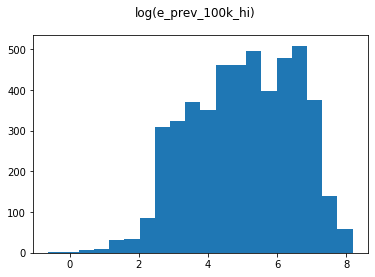

In [11]:
# We'll use the np.log() function and use it as a parameter to the pandas .apply() function
loggedColumnToTest=tbDF[columnToTest].apply(np.log)
fig = sm.qqplot(loggedColumnToTest, stats.norm, line = 'r')
plt.show()

plt.suptitle("log(" + columnToTest + ")")
plt.hist(loggedColumnToTest, 20)

This is now pretty close to normal.

## Part 3: Distributions, Sampling & Robust Statistics 

### Distributions and sampling

We'll get samples of varying sizes from different distributions and observe how the descriptive statistics change. The code to do all of what you were asked looks quite complicated.

To simplify, I've done it for 10 runs of 3 sample sizes, plotting the means of each.

(Hopefully) you can see how you would use a different distribution, different statistics and different distribution parameters.

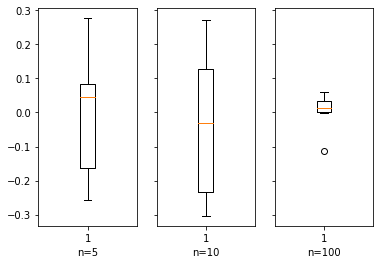

In [16]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

sampleSize=[5,10,100]

# Parameters of our distribution
meanParam=0
spreadParam=0.5


#empty list to store our means
meanEstimations = []

for i in range (len(sampleSize)):  #for each sample size...
    meanEstimations.append([])          #add an empty list to store the means for this run
    for j in range (10):                #Do 10 sampling runs. For each...
        #sample the value from the distribution
        sampledArray = np.random.normal(meanParam, spreadParam, sampleSize[i]) 
        #put the mean into the mean estimates for this run
        meanEstimations[i].append(np.mean(sampledArray))                       

#Plot them
series=[] #list to store the series names
for i in range (len(sampleSize)):          #for each sample size experiment
    plt.plot(meanEstimations[i])           #plot the 10 means
    series.append("n="+str(sampleSize[i])) #add the series name

plt.legend(series, loc='upper left')       #draw the legend
plt.title("Means of 10 samples with different ns")
plt.xlabel("Experiment number")
plt.ylabel("Mean")
plt.show()

f, axes = plt.subplots(1, len(sampleSize), sharey=True)
for i in range (len(sampleSize)):
    axes[i].boxplot(meanEstimations[i])
    axes[i].set_xlabel("n="+str(sampleSize[i]))
plt.show()


Note that the higher n, the more stable the means, because we're sampling a greater amount of the 'population'. The purple line in the line graph has largest sample size (n=100) and is the most constant. Try running the code (above) again to see how it's changing. Analyses are more robust when we have larger sample sizes.

The boxplots confirm that the spread of the means is smaller the more samples are picked. Boxplots show this very effectively.

### (Optional extra: reshaping the data to plot more easily)

You'll remember than in week 2 we learnt about tidy data. As mentioned, some libraries work better when your data are tidy.

Seaborne is a charting library similar to (and based on) matplotlib. If your data are tidy, it will let you plot multiple column, without having to loop through variables as above.

`experimentMeans` is a list of lists, which we can convert to a data frame. Each row is an experiment (with different `n` and each column is sampling run.

To tidy it, we will need to *transpose* it so that each experiment is a column, and then *tidy* is by using Panda's `melt()` function.

In [17]:
rownames=[]
for i in range (len(sampleSize)):
    rownames.append("n="+str(sampleSize[i]))

experimentMeansDF= pd.DataFrame(meanEstimations, index=rownames) 
experimentMeansDF=experimentMeansDF.transpose()
#print(experimentMeansDF)
tidyExperiment=experimentMeansDF.melt(var_name="Experiment", value_name="Means")
#print(tidyExperiment.head())

import seaborn as sns
sns.boxplot(data=tidyExperiment, x="Experiment", y="Means")

### Robust statistics


Here we're just comparing some robust vs non-robust statistics for a distribution with lots of outliers. We choose a highly skewed data column.

mean: 378.13700122649203 median 165.0
std: 500.49692360689403 iqr 479.0
std: 500.49692360689403 mad 210.52951502779547


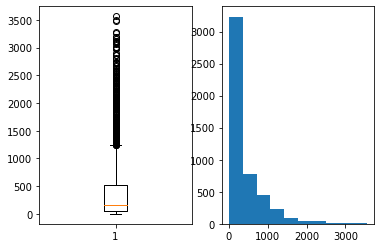

In [18]:
# Here we choose a skewed data column from the data and observe the 
colToTest = "e_prev_100k_hi" 

f, ax = plt.subplots(1, 2)
ax[0].boxplot(tbDF[colToTest])
ax[1].hist(tbDF[colToTest])

print('mean:', tbDF[colToTest].mean(),'median', tbDF[colToTest].median())
print('std:', tbDF[colToTest].std(),'iqr', stats.iqr(tbDF[colToTest]))
print('std:', tbDF[colToTest].std(),'mad', sm.robust.scale.mad(tbDF[colToTest]))

The histogram shows how skewed it is and the box-plot shows the outliers more effectively than the histogram. Notice the marked differences between the 'non-robust' and 'robust statistics. The 'non-robust' statistics are seriously affected by the outliers.